#### The purpose of this script is to compare reprogramming and neurogenesis, via:
* DE analysis within each cell cluster
* Gene clustering

# 0 Load packages <a name="loading"></a> 

In [1]:
import sys
import pickle
print(sys.executable)
print(sys.path)
print(sys.version)

/home2/s418610/.conda/envs/py37_res_diffxpy_2/bin/python
['/home2/s418610/jupyter_notebooks/03.Invivo_neuronal_reprogramming/Manuscript/to_GitHub/Adult_neurogenesis', '', '/cm/shared/apps/cnvkit/0.9.5/lib/python3.6/site-packages', '/cm/shared/apps/python/3.6.4-anaconda/lib', '/cm/shared/apps/jupyterkernel-matlab/0.16.1/lib/python3.6/site-packages', '/cm/shared/apps/python/2.7.x-anaconda/lib', '/home2/s418610/.conda/envs/py37_res_diffxpy_2/lib/python37.zip', '/home2/s418610/.conda/envs/py37_res_diffxpy_2/lib/python3.7', '/home2/s418610/.conda/envs/py37_res_diffxpy_2/lib/python3.7/lib-dynload', '/home2/s418610/.local/lib/python3.7/site-packages', '/home2/s418610/.conda/envs/py37_res_diffxpy_2/lib/python3.7/site-packages', '/home2/s418610/.conda/envs/py37_res_diffxpy_2/lib/python3.7/site-packages/fa2-0.3.5-py3.7-linux-x86_64.egg', '/home2/s418610/.conda/envs/py37_res_diffxpy_2/libexec/batchglm', '/home2/s418610/.conda/envs/py37_res_diffxpy_2/libexec/diffxpy', '/home2/s418610/.conda/envs/p

In [2]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.sparse


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import harmonypy as hm

In [3]:
%load_ext autoreload
%autoreload 2

import anndata
# import matplotlib.pyplot as plt
# import seaborn as sns
# import logging
import scipy.stats


In [4]:
import diffxpy.api as de

In [5]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scipy', scipy.__version__)
# print('sklearn', sklearn.__version__)
# print('statsmodels', sm.__version__)
print('matplotlib', mpl.__version__)
print('seaborn', sns.__version__)

sc.logging.print_versions()

!date +%F

numpy 1.17.2
pandas 0.25.2
scipy 1.3.1
matplotlib 3.3.2
seaborn 0.9.0
scanpy==1.4.5.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
2021-08-04


# 1 Load data

In [6]:
data_dir = '/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/Cluster_with_10X_20k/data/10x_remapped/Revision/'
neural_data_dir = data_dir + 'NeuralOnly/'

In [7]:
adata_neural = sc.read(neural_data_dir + 'ReprNeur_NeuralOnly_postFiltering_log_pcs50_Harmony_louvain_ann.h5ad')

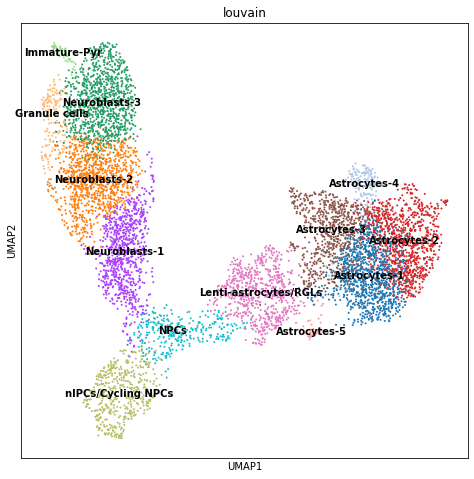

In [8]:
sc.pl.umap(adata_neural, color='louvain', legend_loc='on data')

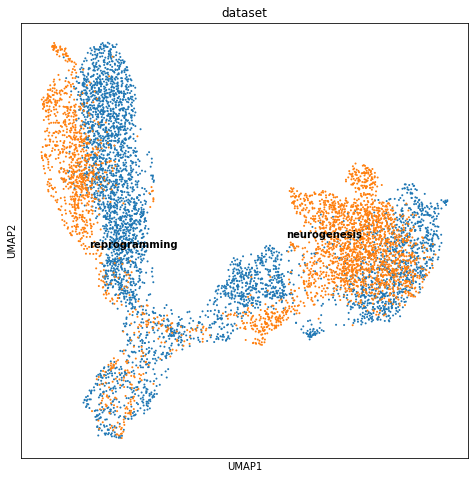

In [9]:
sc.pl.umap(adata_neural, color='dataset', legend_loc='on data')

# 2 Differential expression analysis

#### For each cluster on the trajectory, perform DE analysis between lenti-DLX2 cells and WT E18.5 cells
* Exclude astrocyte clusters (will compare resident astrocytes in a following section)
* Exclude granule cells and immature-pyr cells(no reprogrammed cells)

Also, exclude all lenti-GFP control cells. 

### 2.1 Prepare dataset

#### Exclude lenti-GFP control cells

In [10]:
exclude = adata_neural.obs['library_name'] == 'BL42_control'

In [11]:
include = [not index for index in exclude]

In [12]:
assert sum(include) == 7289

In [13]:
adata_DE = adata_neural[include, :]

In [14]:
adata_DE

View of AnnData object with n_obs × n_vars = 7289 × 2500 
    obs: 'SRR run accession', 'UMI_CellularBarcode', 'batch', 'characteristics: age', 'characteristics: cell cluster', 'characteristics: sex of pooled animals', 'characteristics: strain', 'dataset', 'doublet_scores', 'lenti_count', 'lenti_log1p_count', 'library_name', 'log_counts', 'molecule', 'mt_count', 'mt_frac', 'n_counts', 'n_genes', 'organism', 'predicted_doublets', 'raw file (original file name)', 'source name', 'tdT_count', 'tdT_log1p_count', 'n_counts_all', 'louvain'
    var: 'gene_ids-reprogramming', 'feature_types-reprogramming', 'genome-reprogramming', 'n_cells-reprogramming', 'n_cells-neurogenesis', 'n_counts'
    uns: 'characteristics: cell cluster_colors', 'dataset_colors', 'dendrogram_louvain', 'library_name_colors', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'Harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

#### Exclude clusters not of interest

In [15]:
adata_DE.obs['louvain'].cat.categories

Index(['Astrocytes-1', 'Neuroblasts-2', 'Neuroblasts-3', 'Astrocytes-2',
       'Neuroblasts-1', 'Astrocytes-3', 'Lenti-astrocytes/RGLs',
       'nIPCs/Cycling NPCs', 'NPCs', 'Astrocytes-4', 'Granule cells',
       'Immature-Pyr', 'Astrocytes-5'],
      dtype='object')

In [16]:
exclude = adata_DE.obs['louvain'].isin(['Astrocytes-1', 'Astrocytes-2', 'Astrocytes-3',
                                        'Astrocytes-4', 'Astrocytes-5', 'Granule cells',
                                        'Immature-Pyr'])

In [17]:
include = [not index for index in exclude]

In [18]:
assert sum(include) == 4203

In [19]:
# Create an AnnData object for Clusters Of Interest (coi)
adata_DE_coi = adata_DE[include, :]

In [20]:
adata_DE_coi.var_names_make_unique()

In [21]:
adata_DE_coi.obs_names_make_unique()

In [22]:
adata_DE_coi

View of AnnData object with n_obs × n_vars = 4203 × 2500 
    obs: 'SRR run accession', 'UMI_CellularBarcode', 'batch', 'characteristics: age', 'characteristics: cell cluster', 'characteristics: sex of pooled animals', 'characteristics: strain', 'dataset', 'doublet_scores', 'lenti_count', 'lenti_log1p_count', 'library_name', 'log_counts', 'molecule', 'mt_count', 'mt_frac', 'n_counts', 'n_genes', 'organism', 'predicted_doublets', 'raw file (original file name)', 'source name', 'tdT_count', 'tdT_log1p_count', 'n_counts_all', 'louvain'
    var: 'gene_ids-reprogramming', 'feature_types-reprogramming', 'genome-reprogramming', 'n_cells-reprogramming', 'n_cells-neurogenesis', 'n_counts'
    uns: 'characteristics: cell cluster_colors', 'dataset_colors', 'dendrogram_louvain', 'library_name_colors', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'Harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [23]:
adata_DE_coi.obs['louvain'].value_counts()

Neuroblasts-2            1015
Neuroblasts-3             981
Neuroblasts-1             806
Lenti-astrocytes/RGLs     662
nIPCs/Cycling NPCs        422
NPCs                      317
Name: louvain, dtype: int64

#### Create a separate object for astrocytes

In [24]:
include = adata_DE.obs['louvain'].isin(['Astrocytes-1', 'Astrocytes-2', 'Astrocytes-3', 
                                        'Astrocytes-4', 'Astrocytes-5'])

In [25]:
adata_DE_astro = adata_DE[include]

In [26]:
adata_DE_astro

View of AnnData object with n_obs × n_vars = 2871 × 2500 
    obs: 'SRR run accession', 'UMI_CellularBarcode', 'batch', 'characteristics: age', 'characteristics: cell cluster', 'characteristics: sex of pooled animals', 'characteristics: strain', 'dataset', 'doublet_scores', 'lenti_count', 'lenti_log1p_count', 'library_name', 'log_counts', 'molecule', 'mt_count', 'mt_frac', 'n_counts', 'n_genes', 'organism', 'predicted_doublets', 'raw file (original file name)', 'source name', 'tdT_count', 'tdT_log1p_count', 'n_counts_all', 'louvain'
    var: 'gene_ids-reprogramming', 'feature_types-reprogramming', 'genome-reprogramming', 'n_cells-reprogramming', 'n_cells-neurogenesis', 'n_counts'
    uns: 'characteristics: cell cluster_colors', 'dataset_colors', 'dendrogram_louvain', 'library_name_colors', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'Harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [27]:
adata_DE_astro.obs['library_name'].value_counts()

BL41_reprogrammed    979
10X80_2              410
10X80_1              355
10X84_4              354
10X79_1              336
10X79_2              264
10X83_4              173
Name: library_name, dtype: int64

### 2.2 Perform DE analysis within each cluster for 100 iterations

In [28]:
import random

In [29]:
df = pd.DataFrame()

test_list = []
for cluster in adata_DE_coi.obs['louvain'].cat.categories:
#    print('Current cluster is', cluster)
#    print(adata_DE_coi[adata_DE_coi.obs['louvain']==cluster].obs['library_name'].value_counts())
    df[cluster] = adata_DE_coi[adata_DE_coi.obs['louvain']==cluster].obs['library_name'].value_counts()

df = df.T

In [30]:
# Summarize numbers of cells within each cluster
df_new = pd.DataFrame(data={
    'lenti-DLX2': df['BL41_reprogrammed'].values, 
    'adult_neurogenesis': df[df.columns.tolist()[1:]].sum(axis=1).values
}, index=df.index)

df_new

,lenti-DLX2,adult_neurogenesis
Neuroblasts-2,511,504
Neuroblasts-3,839,142
Neuroblasts-1,716,90
Lenti-astrocytes/RGLs,462,200
nIPCs/Cycling NPCs,292,130
NPCs,239,78


In light of these, for each iteration of DE analysis, we will randomly select 70 lenti-DLX2 cells and 70 WT E18.5 cells. We will repeat this 100 times for each cell type. 

In [31]:
adata_DE_coi.obs['dataset']

index
AAACCCACACAGGATG-1         reprogramming
AAACGCTCATTAGGAA-1         reprogramming
AAACGCTGTAGACAAT-1         reprogramming
AAACGCTGTGTGTCCG-1         reprogramming
AAACGCTTCAAGGTGG-1         reprogramming
                               ...      
10X79_1_GGGCTGTACAGTTC-     neurogenesis
10X83_4_GAGCTGTACATGTC-     neurogenesis
10X83_4_TCCACCAATAGCGG-     neurogenesis
10X83_4_TCCAGGTCGGATCC-     neurogenesis
10X83_4_CTGCGTCGTGACAT-     neurogenesis
Name: dataset, Length: 4203, dtype: category
Categories (2, object): [reprogramming, neurogenesis]

In [ ]:
test_list_collection = []
for _ in range(100):
    # Initialize an empty test_list
    test_list = []
    print('Current iteration:', _)

    # DE test for all clusters except resident astrocytes
    for cluster in adata_DE_coi.obs['louvain'].cat.categories:
        adata_DE_test = adata_DE_coi[adata_DE_coi.obs['louvain']==cluster]

        index_include = random.choices(adata_DE_test.obs.index[adata_DE_test.obs['dataset'] == 'reprogramming'], k=70)
        index_include = index_include + random.choices(adata_DE_test.obs.index[adata_DE_test.obs['dataset'] == 'neurogenesis'], k=70)

        adata_DE_test = adata_DE_test[index_include]

        adata_DE_test = anndata.AnnData(X=adata_DE_test.raw.X, 
                                       obs=adata_DE_test.obs, 
                                       var=adata_DE_test.raw.var)

        adata_DE_test.var_names_make_unique()

        # Use two-sample wrapper from diffxpy
        test_cluster = de.test.two_sample(data=adata_DE_test, 
                                          grouping='dataset', 
                                          test='rank')

        test_list.append((cluster, test_cluster))

    # DE test for resident astrocytes
    index_include = random.choices(adata_DE_astro.obs.index[adata_DE_astro.obs['dataset'] == 'reprogramming'], k=70)
    index_include = index_include + random.choices(adata_DE_astro.obs.index[adata_DE_astro.obs['dataset'] == 'neurogenesis'], k=70)
    
    adata_DE_test = adata_DE_astro.copy()
    adata_DE_test = adata_DE_test[index_include]


    adata_DE_test = anndata.AnnData(X=adata_DE_test.raw.X, 
                                   obs=adata_DE_test.obs, 
                                   var=adata_DE_test.raw.var)

    adata_DE_test.var_names_make_unique()

    # Use two-sample wrapper
    test_astro = de.test.two_sample(data=adata_DE_test, 
                                      grouping='dataset', 
                                      test='rank')
    test_list.append(('Astrocytes', test_astro))
    
    test_list_collection.append(test_list)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 0


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 1


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 2


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 3


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 4


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 5


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 6


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 7


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 8


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 9


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 10


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 11


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 12


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 13


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 14


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 15


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 16


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 17


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 18


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 19


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 20


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 21


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 22


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 23


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 24


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 25


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 26


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 27


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 28


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 29


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 30


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 31


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 32


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 33


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 34


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 35


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 36


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 37


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 38


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 39


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 40


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 41


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 42


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 43


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 44


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 45


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 46


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 47


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 48


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 49


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 50


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 51


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 52


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 53


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 54


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 55


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 56


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 57


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 58


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 59


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 60


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 61


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 62


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 63


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 64


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 65


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 66


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 67


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 68


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 69


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 70


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 71


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 72


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 73


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 74


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 75


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [ ]:
assert len(test_list_collection)==100

##### Write and read data

In [ ]:
DE_dir = data_dir + 'DE_analysis/'

In [ ]:
output_path = DE_dir + 'adult_neurogenesis_test_list_collection_100iter'

with open(output_path, 'wb') as output_file:
 
    pickle.dump(test_list_collection, output_file)

In [36]:
input_path = DE_dir + 'adult_neurogenesis_test_list_collection_100iter'
with open(input_path, 'rb') as input_file:
 
    test_list_collection = pickle.load(input_file)

In [37]:
assert len(test_list_collection)==100

### 2.3 Extract data from results

In [38]:
# Extract numbers of genes up in lenti-DLX2 cells with q value < 0.01 and fold change > 2 from each cell type
data_experimental_up = {}
for i, iteration in enumerate(test_list_collection):
    tmp_data = []
    for cluster, test_cluster in iteration:
        tmp_data.append(sum(np.logical_and(test_cluster.summary()['qval'] < 0.01, test_cluster.summary()['log2fc'] > 1)))
    data_experimental_up[i] = tmp_data

df_experimental_up = pd.DataFrame(data_experimental_up)

clusters = {}
for i, (cluster, _) in enumerate(test_list_collection[0]):
    clusters[i] = cluster
df_experimental_up.rename(index=clusters, inplace=True)

In [39]:
# Extract numbers of genes up in WT E18.5 cells with q value < 0.01 and fold change > 2 from each cell type
data_public_up = {}
for i, iteration in enumerate(test_list_collection):
    tmp_data = []
    for cluster, test_cluster in iteration:
        tmp_data.append(sum(np.logical_and(test_cluster.summary()['qval'] < 0.01, test_cluster.summary()['log2fc'] < -1)))
    data_public_up[i] = tmp_data

df_public_up = pd.DataFrame(data_public_up)

clusters = {}
for i, (cluster, _) in enumerate(test_list_collection[0]):
    clusters[i] = cluster
df_public_up.rename(index=clusters, inplace=True)

### 2.4 Plot the results

In [40]:
df_experimental_up['mean'] = df_experimental_up.mean(axis=1)

In [41]:
df_experimental_up['std'] = df_experimental_up.std(axis=1)

In [42]:
df_experimental_up

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,mean,std
Neuroblasts-2,592,544,534,449,624,509,639,538,524,455,...,508,491,359,413,629,414,603,523,494.29,78.472963
Neuroblasts-3,526,397,409,433,411,481,375,516,378,458,...,520,434,457,388,451,494,498,538,452.20,65.299770
Neuroblasts-1,799,1106,831,1317,754,762,682,740,679,1345,...,862,1051,1059,798,672,575,705,768,893.22,192.845720
Lenti-astrocytes/RGLs,4180,3991,3940,3936,3490,3327,3629,3262,3859,3182,...,3775,3359,3346,2656,3645,3508,3206,3783,3489.52,376.138019
nIPCs/Cycling NPCs,4208,4484,3360,4503,3621,4535,4649,3695,3699,3410,...,3329,3833,5053,4402,4247,4182,3766,3584,3926.12,473.696449
NPCs,3572,4035,3828,3780,4008,3948,4594,3612,3947,4536,...,4229,3822,4063,3189,3980,3755,3661,3777,4003.67,375.198536
Astrocytes,1313,1002,1080,1148,1000,1002,1326,894,987,1016,...,991,1072,787,770,1267,897,1004,954,1048.51,162.841364


In [43]:
df_public_up['mean'] = df_public_up.mean(axis=1)

In [44]:
df_public_up['std'] = df_public_up.std(axis=1)

In [45]:
df_public_up

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,mean,std
Neuroblasts-2,171,147,136,141,131,144,148,174,148,144,...,165,144,159,170,147,159,133,161,149.54,15.715228
Neuroblasts-3,236,280,260,316,303,292,303,264,317,287,...,286,277,319,347,254,295,278,267,291.79,30.777685
Neuroblasts-1,102,89,110,99,127,104,123,109,123,87,...,121,101,119,84,104,110,147,124,106.67,12.980027
Lenti-astrocytes/RGLs,78,79,74,74,86,100,87,84,71,76,...,82,80,91,91,80,70,91,83,81.96,9.320858
nIPCs/Cycling NPCs,68,71,82,74,85,77,73,77,86,87,...,76,79,72,71,70,73,80,67,73.87,7.461441
NPCs,89,74,74,80,67,68,73,82,74,68,...,59,89,67,89,79,76,70,75,70.85,9.690588
Astrocytes,42,27,42,41,34,40,39,46,36,43,...,45,35,48,52,41,51,43,46,42.64,6.229799


In [46]:
# Order based on cluster-averaged pseudotime
row_order = ['Astrocytes', 'Lenti-astrocytes/RGLs', 'NPCs', 
            'nIPCs/Cycling NPCs', 'Neuroblasts-1', 'Neuroblasts-2', 
            'Neuroblasts-3']

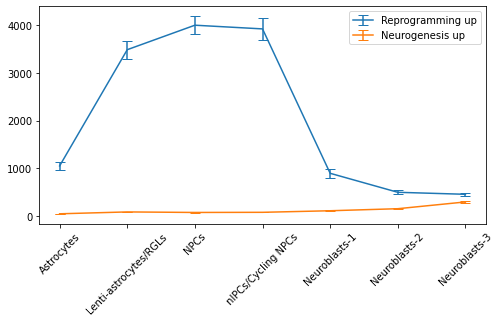

In [47]:
# Figure 3E, top
fig, ax = plt.subplots(figsize=(8,4))
x = np.arange(len(row_order))

y_experimental_up = df_experimental_up.loc[row_order]['mean']
error_experimental_up = df_experimental_up.loc[row_order]['std']

y_public_up = df_public_up.loc[row_order]['mean']
error_public_up = df_public_up.loc[row_order]['std']

plt.errorbar(x, y_experimental_up, error_experimental_up/2, capsize=5)
plt.errorbar(x, y_public_up, error_public_up/2, capsize=5)

plt.xticks(x, row_order, rotation=45)
plt.legend(['Reprogramming up', 'Neurogenesis up'], loc='best')

# plt.savefig('/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/99.Manuscript/Figures_v2/linechart_n_DEGs_100iter_MT.pdf')
plt.show()

### Explore commonly differentially expressed genes across all cell types (these are likely result of batch effect)

In [48]:
test_list_all = test_list_collection[0]

In [49]:
from collections import Counter

In [50]:
experiment_up_list = []

In [51]:
for _, test_instance in test_list_all:
    experiment_up_list.append(test_instance.summary()[np.logical_and(test_instance.summary()['qval'] < 1e-10, test_instance.summary()['log2fc'] > 2)]['gene'].tolist())

In [52]:
# The genes that show enrichment in experimental cells in every cluster
set(experiment_up_list[0]).intersection(*experiment_up_list)

{'AY036118', 'Gm42418', 'Lars2'}

In [53]:
experiment_up_flat = [gene for gene_list in experiment_up_list for gene in gene_list]

In [54]:
counter_experiment_up = Counter(experiment_up_flat)

([<matplotlib.axis.XTick at 0x7fff92536128>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

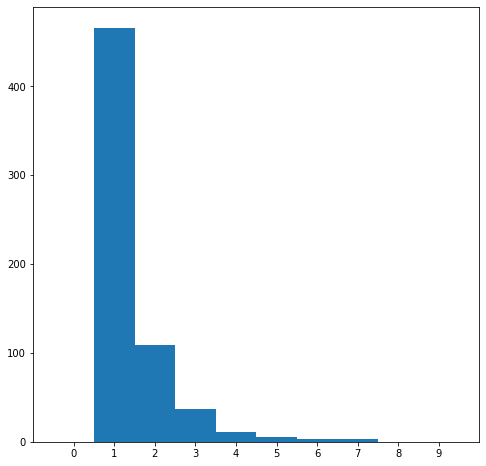

In [55]:
plt.hist([i for gene, i in counter_experiment_up.most_common()], 
        bins=[i-0.5 for i in range(11)], 
        histtype='bar')
plt.xticks(ticks=range(10))

In [56]:
counter_experiment_up.most_common(20)

[('Lars2', 7),
 ('Gm42418', 7),
 ('AY036118', 7),
 ('Meis2', 6),
 ('Hnrnpa0', 6),
 ('Prrc2c', 6),
 ('Gad2', 5),
 ('Dlx1', 5),
 ('Gm13889', 5),
 ('Nrxn3', 5),
 ('Ifi27', 5),
 ('Sp9', 4),
 ('Arx', 4),
 ('S100a10', 4),
 ('Dlx6os1', 4),
 ('Ccdc88a', 4),
 ('Rtn4', 4),
 ('Hist1h1e', 4),
 ('Id4', 4),
 ('Eid1', 4)]

#### Examine genes enriched in public cells

In [57]:
public_up_list = []

In [58]:
for _, test_instance in test_list_all:
    public_up_list.append(test_instance.summary()[np.logical_and(test_instance.summary()['qval'] < 1e-10, test_instance.summary()['log2fc'] < -2)]['gene'].tolist())

In [59]:
set(public_up_list[0]).intersection(*public_up_list)

{'Gm10076', 'Rps27'}

In [60]:
public_up_flat = [gene for gene_list in public_up_list for gene in gene_list]

In [61]:
counter_public_up = Counter(public_up_flat)

([<matplotlib.axis.XTick at 0x7fff9e0a4160>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

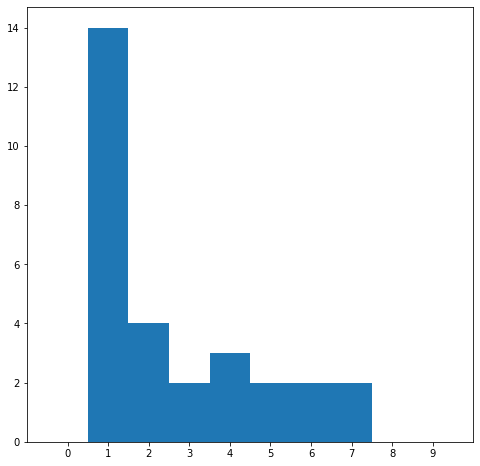

In [62]:
plt.hist([i for gene, i in counter_public_up.most_common()], 
        bins=[i-0.5 for i in range(11)], 
        histtype='bar')
plt.xticks(ticks=range(10))

In [63]:
counter_public_up.most_common(20)

[('Rps27', 7),
 ('Gm10076', 7),
 ('Rpl10', 6),
 ('Gm10260', 6),
 ('Rps12', 5),
 ('Rpl27', 5),
 ('Gm8797', 4),
 ('Rpl9', 4),
 ('Uba52', 4),
 ('Gm2000', 3),
 ('Pcp4', 3),
 ('Neurod1', 2),
 ('Bhlhe22', 2),
 ('Snca', 2),
 ('Cnih2', 2),
 ('Snrpg', 1),
 ('Calb2', 1),
 ('Erh', 1),
 ('Prox1', 1),
 ('Plppr4', 1)]